## 작업

In [1]:
import shutil

# 현재 작업 디렉토리의 디스크 사용량을 확인
total, used, free = shutil.disk_usage(".")

print(f"Total: {total // (2**30)} GB")
print(f"Used: {used // (2**30)} GB")
print(f"Free: {free // (2**30)} GB")
print("hello")

Total: 223 GB
Used: 151 GB
Free: 72 GB
hello


In [2]:
import cv2
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
import os
import pandas as pd
import torch

In [4]:
# 데이터 경로 정의
train2017='train2017/train2017/'
train_annotation2017='annotations/instances_train2017.json'
val2017='val2017/val2017/'
val_annotation2017='annotations/instances_val2017.json'

In [5]:
# device 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [6]:
# JSON 파일을 불러옴
with open(train_annotation2017) as t:
    t_data = json.load(t)

with open(val_annotation2017) as v:
    v_data = json.load(v)

In [7]:
unique_keys = list(t_data.keys())
print(unique_keys)

['info', 'licenses', 'images', 'annotations', 'categories']


In [8]:
# 학습 데이터에서 어노테이션, 이미지, 카테고리 정보를 추출
t_annotations = t_data['annotations']
t_train_images = t_data['images']
t_categories = t_data['categories']

# 데이터프레임으로 변환
t_annotations_df = pd.DataFrame(t_annotations)
t_images_df = pd.DataFrame(t_train_images)
t_categories_df = pd.DataFrame(t_categories)

In [9]:
# 검증 데이터에서 어노테이션, 이미지, 카테고리 정보를 추출
v_annotations = v_data['annotations']
v_train_images = v_data['images']
v_categories = v_data['categories']

# 데이터프레임으로 변환
v_annotations_df = pd.DataFrame(v_annotations)
v_images_df = pd.DataFrame(v_train_images)
v_categories_df = pd.DataFrame(v_categories)

In [10]:
#  두 데이터프레임을 'id'와 'image_id' 열을 기준으로 내부 머지
train_df = pd.merge(t_images_df, t_annotations_df, how="inner", left_on='id', right_on='image_id')

In [11]:
t_images_df.head(2)

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,000000522418.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418


In [12]:
t_annotations_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
1,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509


In [13]:
t_categories_df.head(2)

,supercategory,id,name
0,person,1,person
1,vehicle,2,bicycle


In [14]:
train_df.head(2)

,license,file_name,coco_url,height,width,date_captured,flickr_url,id_x,segmentation,area,iscrowd,image_id,bbox,category_id,id_y
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895,"[[376.97, 176.91, 398.81, 176.91, 396.38, 147....",12190.44565,0,391895,"[359.17, 146.17, 112.45, 213.57]",4,151091
1,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895,"[[352.55, 146.82, 353.61, 137.66, 356.07, 112....",14107.27130,0,391895,"[339.88, 22.16, 153.88, 300.73]",1,202758


In [15]:
# 기존 데이터프레임과 카테고리 데이터프레임을 내부 머지
train_df = pd.merge(train_df, t_categories_df, how="inner", left_on='category_id', right_on='id')

# 불필요한 열을 제거
train_df.drop(["id_x", "id"], axis=1, inplace=True)

# 열 이름을 직관적으로 변경
train_df.rename(columns={
    "id_y": "object_id",
    "name": "category_name"
}, inplace=True)

In [16]:
#  두 데이터프레임을 'id'와 'image_id' 열을 기준으로 내부 머지
val_df = pd.merge(v_images_df, v_annotations_df, how="inner", left_on='id', right_on='image_id')

# 기존 데이터프레임과 카테고리 데이터프레임을 내부 머지
val_df = pd.merge(val_df, v_categories_df, how="inner", left_on='category_id', right_on='id')

# 불필요한 열을 제거
val_df.drop(["id_x", "id"], axis=1, inplace=True)

# 열 이름을 직관적으로 변경
val_df.rename(columns={
    "id_y": "object_id",
    "name": "category_name"
}, inplace=True)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860001 entries, 0 to 860000
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   license        860001 non-null  int64  
 1   file_name      860001 non-null  object 
 2   coco_url       860001 non-null  object 
 3   height         860001 non-null  int64  
 4   width          860001 non-null  int64  
 5   date_captured  860001 non-null  object 
 6   flickr_url     860001 non-null  object 
 7   segmentation   860001 non-null  object 
 8   area           860001 non-null  float64
 9   iscrowd        860001 non-null  int64  
 10  image_id       860001 non-null  int64  
 11  bbox           860001 non-null  object 
 12  category_id    860001 non-null  int64  
 13  object_id      860001 non-null  int64  
 14  supercategory  860001 non-null  object 
 15  category_name  860001 non-null  object 
dtypes: float64(1), int64(7), object(8)
memory usage: 111.5+ MB


In [18]:
train_df.head(2)

,license,file_name,coco_url,height,width,date_captured,flickr_url,segmentation,area,iscrowd,image_id,bbox,category_id,object_id,supercategory,category_name
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,"[[376.97, 176.91, 398.81, 176.91, 396.38, 147....",12190.44565,0,391895,"[359.17, 146.17, 112.45, 213.57]",4,151091,vehicle,motorcycle
1,6,000000321107.jpg,http://images.cocodataset.org/train2017/000000...,480,269,2013-11-15 03:14:32,http://farm4.staticflickr.com/3038/4555159978_...,"[[154.31, 133.65, 136.67, 144.1, 132.1, 123.85...",1080.08415,0,321107,"[132.1, 90.53, 43.77, 65.99]",4,148023,vehicle,motorcycle


In [19]:
def is_rle(segmentation):
    return isinstance(segmentation, dict)

# 'segmentation' 컬럼에 적용하여 RLE 형식의 데이터를 필터링
rle_rows_t = train_df[train_df['segmentation'].apply(is_rle)]
rle_rows_v = val_df[val_df['segmentation'].apply(is_rle)]

# rle_rows_t.head(2)
rle_rows_v.head(2)

,license,file_name,coco_url,height,width,date_captured,flickr_url,segmentation,area,iscrowd,image_id,bbox,category_id,object_id,supercategory,category_name
89,2,000000340697.jpg,http://images.cocodataset.org/val2017/00000034...,333,500,2013-11-23 06:00:01,http://farm1.staticflickr.com/47/170703099_b61...,"{'counts': [21392, 13, 318, 17, 315, 19, 313, ...",41635.0,1,340697,"[64, 0, 435, 296]",44,904400340697,kitchen,bottle
212,4,000000213547.jpg,http://images.cocodataset.org/val2017/00000021...,640,480,2013-11-18 20:21:16,http://farm3.staticflickr.com/2062/2243132921_...,"{'counts': [17021, 8, 629, 12, 615, 26, 604, 3...",9322.0,1,213547,"[26, 131, 453, 304]",44,904400213547,kitchen,bottle


In [20]:
from pycocotools import mask as cocomask
import cv2

# RLE 데이터를 COCO포맷의 다각형 형태로 변환하는 함수
def rle_to_coco(annotation):

    # frPyObjects 함수를 사용하여 RLE 형태의 'segmentation' 데이터를 마스크로 변환
    # 이 마스크는 세그멘테이션 정보를 픽셀 레벨에서 나타냄
    rle_obj = cocomask.frPyObjects(annotation["segmentation"],
                                   annotation["segmentation"]["size"][0],
                                   annotation["segmentation"]["size"][1])
    mask = cocomask.decode(rle_obj)  # 디코딩하여 numpy 배열 형태의 이진 마스크 얻음

    # OpenCV의 findContours 함수를 사용하여 마스크에서 윤곽선(경계선)을 찾음
    # 찾아진 윤곽선 정보는 다각형의 꼭짓점 정보로 활용
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    annotations = []  # 변환된 다각형 정보를 저장할 리스트를 초기화

    for contour in contours:
        # 윤곽선의 크기가 6 이상인 경우(각 점은 x, y 좌표를 가지는 최소한 삼각형 형태의 윤곽선)처리
        if contour.size >= 6:
            bbox = cv2.boundingRect(contour)  # 윤곽선을 둘러싸는 최소 크기의 바운딩 박스를 계산
            area = cv2.contourArea(contour)  # 윤곽선으로 둘러싸인 영역의 면적을 계산
            segmentation = [contour.flatten().tolist()]  # 윤곽선의 좌표를 평탄화하고 리스트로 변환

            # 변환된 정보(다각형의 세그멘테이션 정보, 바운딩 박스, 면적)를 annotations 리스트에 추가.
            annotations.append({
                "segmentation": segmentation,
                "bbox": list(bbox),
                "area": area
            })
    return annotations

In [21]:
# RLE 형태의 세그멘테이션 데이터를 COCO 포맷의 다각형 형태로 변환하는 함수
def transform_rle_to_polygon(data):

    # 'iscrowd'가 1인 경우(세그멘테이션이 RLE 형식)의 데이터만 선택하여 복사
    data_annot_rle = data[data['iscrowd'] == 1].copy()

    registros_transformados = pd.DataFrame()  # 변환된 기록을 저장할 DataFrame을 초기화
    temp_dfs = []  # 임시로 변환된 기록을 저장할 리스트를 생성

    # RLE 데이터를 포함한 각 행에 대해 반복
    for i, row in data_annot_rle.iterrows():
        # 현재 행의 세그멘테이션 데이터를 다각형 형태로 변환
        annotations = rle_to_coco(row)

        # 변환된 각 세그멘테이션에 대해 반복
        for annotation in annotations:
            registro = row.to_dict()  # 현재 행의 데이터를 딕셔너리 형태로 복사
            registro.update(annotation)  # 변환된 세그멘테이션 데이터로 업데이트
            temp_dfs.append(pd.DataFrame([registro]))  # 변환된 기록을 임시 리스트에 추가

    # 모든 임시 DataFrame들을 합침
    registros_transformados = pd.concat(temp_dfs, ignore_index=True)

    # 원본 데이터에서 'iscrowd'가 1인 행을 제거하고, 변환된 데이터를 추가
    data_annot = pd.concat([data.drop(data_annot_rle.index), registros_transformados], ignore_index=True)

    return data_annot

In [22]:
# 함수를 사용해 새로운 데이터프레임 생성
new_train_df = transform_rle_to_polygon(train_df)
new_val_df = transform_rle_to_polygon(val_df)

new_train_df.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,segmentation,area,iscrowd,image_id,bbox,category_id,object_id,supercategory,category_name
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,"[[376.97, 176.91, 398.81, 176.91, 396.38, 147....",12190.44565,0,391895,"[359.17, 146.17, 112.45, 213.57]",4,151091,vehicle,motorcycle
1,6,000000321107.jpg,http://images.cocodataset.org/train2017/000000...,480,269,2013-11-15 03:14:32,http://farm4.staticflickr.com/3038/4555159978_...,"[[154.31, 133.65, 136.67, 144.1, 132.1, 123.85...",1080.08415,0,321107,"[132.1, 90.53, 43.77, 65.99]",4,148023,vehicle,motorcycle
2,5,000000232262.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-15 05:23:22,http://farm9.staticflickr.com/8048/8089005305_...,"[[47.22, 231.67, 47.39, 240.26, 51.17, 239.57,...",434.03400,0,232262,"[28.49, 224.45, 25.6, 32.82]",4,150811,vehicle,motorcycle
3,3,000000061181.jpg,http://images.cocodataset.org/train2017/000000...,321,500,2013-11-15 05:26:41,http://farm4.staticflickr.com/3085/2658286283_...,"[[396.61, 179.11, 392.63, 179.02, 391.72, 181....",86.94530,0,61181,"[389.31, 179.02, 9.13, 14.36]",4,152438,vehicle,motorcycle
4,4,000000097434.jpg,http://images.cocodataset.org/train2017/000000...,266,640,2013-11-15 12:18:56,http://farm8.staticflickr.com/7122/7856942124_...,"[[368.66, 210.92, 371.88, 176.11, 369.31, 172....",26226.27955,0,97434,"[368.02, 57.52, 259.09, 169.51]",4,154219,vehicle,motorcycle


In [23]:
from sklearn.preprocessing import LabelEncoder

# 문자열 형태의 레이블을 모델이 처리할 수 있는 형태로 인코딩하기 위해 LabelEncoder 인스턴스를 생성
label_encoder = LabelEncoder()

# 'category_name' 열에 대해 LabelEncoder를 적용
# 학습 데이터프레임(new_train_df)과 검증 데이터프레임(new_val_df)의 'category_name' 열을 숫자로 인코딩하여 새 열로 추가
new_train_df['category_name_encoded'] = label_encoder.fit_transform(new_train_df['category_name'])
new_val_df['category_name_encoded'] = label_encoder.fit_transform(new_val_df['category_name'])

new_train_df['supercategory_encoded'] = label_encoder.fit_transform(new_train_df['supercategory'])
new_val_df['supercategory_encoded'] = label_encoder.fit_transform(new_val_df['supercategory'])

In [24]:
t_person_encoded = new_train_df[new_train_df['category_name'] == 'person']['category_name_encoded'].values[0]
v_person_encoded = new_val_df[new_val_df['category_name'] == 'person']['category_name_encoded'].values[0]
print("t_Person 인코딩된 값:", t_person_encoded)
print("v_Person 인코딩된 값:", v_person_encoded)

t_Person 인코딩된 값: 49
v_Person 인코딩된 값: 49


In [25]:
new_train_df.drop(columns=['category_name', 'supercategory', 'coco_url', 'date_captured', 'flickr_url'], inplace=True)
new_val_df.drop(columns=['category_name', 'supercategory', 'coco_url', 'date_captured', 'flickr_url'], inplace=True)

In [26]:
print(new_train_df.loc[39, 'segmentation'])
print(new_val_df.loc[89, 'segmentation'])
# REL 형식의 segmentation데이터가 다각형 좌표로 변환 됐는지 확인

[[465.38, 324.33, 435.64, 322.41, 442.35, 313.77, 465.38, 309.93, 436.6, 301.3, 433.72, 290.74, 467.3, 296.5, 470.18, 304.18, 484.57, 313.77, 503.76, 312.81, 503.76, 300.34, 498.97, 284.03, 512.4, 281.15, 516.24, 243.73, 546.94, 252.36, 522.0, 271.55, 537.35, 284.99, 545.98, 301.3, 549.82, 327.21, 556.54, 337.76, 558.46, 357.91, 559.42, 381.9, 541.19, 378.06, 524.87, 363.67, 482.65, 341.6, 472.1, 353.11, 465.38, 369.43, 467.3, 388.62, 468.26, 406.85, 337.76, 409.73, 299.38, 399.17, 261.96, 379.02, 276.35, 350.24, 276.35, 334.88, 279.23, 309.93, 304.18, 310.89, 345.44, 331.04, 382.86, 337.76, 409.73, 330.09]]
[[123.17, 327.41, 122.66, 305.13, 117.77, 294.32, 117.77, 288.01, 110.81, 287.75, 110.81, 294.06, 107.46, 305.39, 108.37, 329.08, 123.43, 329.08, 123.3, 327.41]]


In [27]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948919 entries, 0 to 948918
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   license                948919 non-null  int64  
 1   file_name              948919 non-null  object 
 2   height                 948919 non-null  int64  
 3   width                  948919 non-null  int64  
 4   segmentation           948919 non-null  object 
 5   area                   948919 non-null  float64
 6   iscrowd                948919 non-null  int64  
 7   image_id               948919 non-null  int64  
 8   bbox                   948919 non-null  object 
 9   category_id            948919 non-null  int64  
 10  object_id              948919 non-null  int64  
 11  category_name_encoded  948919 non-null  int32  
 12  supercategory_encoded  948919 non-null  int32  
dtypes: float64(1), int32(2), int64(7), object(3)
memory usage: 86.9+ MB


In [28]:
# 'segmentation'과 'bbox' 열을 제외하고 중복 행 확인
t_columns_to_check = new_train_df.columns.difference(['segmentation', 'bbox'])
t_duplicated_rows = new_train_df.duplicated(subset=t_columns_to_check)
print(f"중복된 행의 개수: {t_duplicated_rows.sum()}")

중복된 행의 개수: 13778


In [29]:
# 'segmentation'과 'bbox' 열을 제외하고 중복 행 확인
v_columns_to_check = new_val_df.columns.difference(['segmentation', 'bbox'])
v_duplicated_rows = new_val_df.duplicated(subset=v_columns_to_check)
print(f"중복된 행의 개수: {v_duplicated_rows.sum()}")

중복된 행의 개수: 541


In [30]:
# 중복된 행을 필터링
new_train_df[t_duplicated_rows].head()

,license,file_name,height,width,segmentation,area,iscrowd,image_id,bbox,category_id,object_id,category_name_encoded,supercategory_encoded
849964,1,000000122302.jpg,375,500,"[[83, 117, 84, 116, 85, 117, 84, 118]]",2.0,1,122302,"[83, 116, 3, 3]",4,900400122302,44,11
849995,1,000000359277.jpg,478,640,"[[349, 259, 350, 260, 350, 261, 351, 262, 351,...",2.5,1,359277,"[349, 259, 3, 5]",4,900400359277,44,11
850022,4,000000270175.jpg,640,480,"[[104, 288, 105, 287, 106, 288, 105, 289]]",2.0,1,270175,"[104, 287, 3, 3]",4,900400270175,44,11
850023,4,000000270175.jpg,640,480,"[[103, 287, 104, 286, 105, 287, 104, 288]]",2.0,1,270175,"[103, 286, 3, 3]",4,900400270175,44,11
850024,4,000000270175.jpg,640,480,"[[102, 286, 103, 285, 104, 286, 103, 287]]",2.0,1,270175,"[102, 285, 3, 3]",4,900400270175,44,11


In [31]:
# 중복 여부를 판단하기 위해 'columns_to_check'에 명시된 열을 기준으로 사용
# 'keep' 파라미터를 'first'로 설정하여 중복된 경우 첫 번째 행만 남기고 나머지 중복 행은 제거
new_train_df = new_train_df.drop_duplicates(subset=t_columns_to_check, keep='first')
new_val_df = new_val_df.drop_duplicates(subset=v_columns_to_check, keep='first')

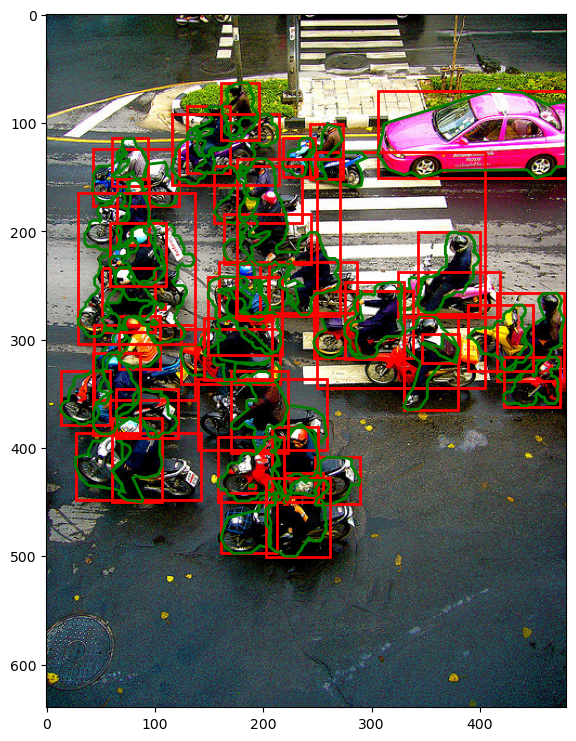

In [32]:
from matplotlib.patches import Rectangle, Polygon

def visualize_image_objects(image_id, dataframe):
    # 해당 이미지 ID에 해당하는 모든 객체 정보를 데이터프레임에서 추출
    # 이를 통해 특정 이미지 내에 있는 모든 객체의 정보를 가져옴
    objects = dataframe[dataframe['image_id'] == image_id]

    # 이미지의 경로를 구성하고 해당 이미지를 로드
    # 'objects.iloc[0]['file_name']'을 통해 특정 이미지 파일의 이름을 얻음
    image_path = f"train2017/train2017/{objects.iloc[0]['file_name']}"
    image = cv2.imread(image_path)

    # OpenCV는 기본적으로 BGR 색상 체계를 사용하기 때문에, 
    # RGB로 변환하여 matplotlib에서 올바르게 이미지를 표시
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # 각 객체에 대해서 반복하면서 시각화를 진행
    for _, obj in objects.iterrows():
        # 각 객체의 바운딩 박스를 추출하고 사각형을 그림
        # 바운딩 박스는 [x, y, width, height] 형태
        bbox = obj['bbox']
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)  # 추출한 사각형을 이미지 위에 그림

        # 각 객체의 세그멘테이션 정보를 추출하고 이미지 위에 그림
        # 세그멘테이션 정보는 다각형의 꼭지점 좌표를 나타냄
        segmentation = np.array(obj['segmentation'][0])
        poly = Polygon(segmentation.reshape(-1, 2), linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(poly)  # 추출한 다각형을 이미지 위에 그림

    plt.show()

# 특정 이미지 ID(중복된 행의 하나)를 가진 이미지와 그 안의 객체들을 시각화
visualize_image_objects(270175, new_train_df)

In [33]:
from torchvision.transforms import functional as F
from torch.utils.data import Dataset

# COCO 데이터셋을 사용하여 특정 객체(여기서는 'person')에 대한 이미지, 바운딩 박스, 세그멘테이션 마스크를
# 처리하고, 모델 학습에 사용할 수 있는 형태로 제공하는 사용자 정의 데이터셋 클래스

class CustomCocoDataset(Dataset):
    def __init__(self, dataframe, image_dir, person_category_encoded, transforms=None, target_size=(128, 128)):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.person_category_encoded = person_category_encoded
        self.transforms = transforms # 이미지에 적용할 전처리 및 데이터 증강(transforms)을 정의함
        self.target_size = target_size # 모든 이미지를 일관적으로 리사이징하기 위한 목표 크기

    # 데이터셋의 총 길이(이미지 수)를 반환
    def __len__(self):
        return len(self.dataframe)

    # 주어진 인덱스에 해당하는 이미지와 세그멘테이션 마스크를 생성하고, 
    # 이미지와 관련된 정보(바운딩 박스, 마스크 등)를 반환
    def create_mask_for_image_and_annotation(self, image_size, segmentation_polygons):
        # 이미지 크기와 같은 단일 채널의 빈 마스크 이미지를 생성
        mask = Image.new('L', image_size, 0)
        # 세그멘테이션 폴리곤을 사용하여 폴리곤 내부는 1로, 외부는 0으로 채움
        for polygon in segmentation_polygons:
            ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)

        # 생성된 마스크 이미지를 numpy 배열로 변환하여 반환
        return np.array(mask, dtype=np.uint8)

    # 생성된 세그멘테이션 마스크를 목표 크기로 리사이징
    def resize_segmentation_mask(self, mask, target_size):
        # numpy 배열로부터 PIL 이미지를 생성하고, 목표 크기로 리사이징
        # 리사이징 방법으로는 NEAREST(가장 가까운 픽셀 사용)를 사용
        mask = Image.fromarray(mask)
        mask = mask.resize(target_size, resample=Image.NEAREST)
        # 리사이징된 마스크를 다시 numpy 배열로 변환하여 반환
        return np.array(mask, dtype=np.uint8)

  # 데이터셋에서 특정 인덱스에 해당하는 데이터(이미지, 타겟 정보)를 가져오는데 
  # 모델 학습 시 배치 단위로 데이터를 로드하는 데 사용
    def __getitem__(self, idx):
        while True:
            # 해당 인덱스의 이미지 정보를 가져오고, 이미지를 로드
            img_info = self.dataframe.iloc[idx % len(self.dataframe)] 
            path = os.path.join(self.image_dir, img_info['file_name'])
            image = Image.open(path).convert("RGB") # 이미지를 RGB 형식으로 변환
            original_size = image.size

            # 이미지를 목표 크기로 리사이징
            image = image.resize(self.target_size)

            # 해당 이미지와 관련된 'person' 객체의 세그멘테이션 정보와 바운딩 박스를 가져옴
            annotations = self.dataframe[self.dataframe['image_id'] == img_info['image_id']]
            annotations = annotations[annotations['category_id'] == self.person_category_encoded]
            # 바운딩 박스가 있는 어노테이션만 필터링
            annotations = annotations[annotations['bbox'].apply(lambda x: len(x) == 4)] 

            # 바운딩 박스가 하나도 없는 경우, 다음 이미지로(사람 객체가 없는 경우)
            if annotations.empty:
                return self.__getitem__((idx + 1) % len(self))

            boxes = []
            masks = []
            # 각 객체에 대한 바운딩 박스를 리사이징하고 저장
            for _, ann in annotations.iterrows():
                bbox = ann['bbox']
                x_min, y_min, width, height = bbox
                x_min = x_min * self.target_size[0] / original_size[0]
                y_min = y_min * self.target_size[1] / original_size[1]
                width = width * self.target_size[0] / original_size[0]
                height = height * self.target_size[1] / original_size[1]

                # 너비와 높이가 0보다 큰 경우에만 처리
                if width > 0 and height > 0:
                    x_max = x_min + width
                    y_max = y_min + height
                    boxes.append([x_min, y_min, x_max, y_max])

                    # 세그멘테이션 마스크를 리사이징 후 저장하고 세그멘테이션 정보가 있는 경우에만 수행
                    if 'segmentation' in ann:
                        segmentation_polygons = ann['segmentation']
                        mask = self.create_mask_for_image_and_annotation(original_size, segmentation_polygons)
                        mask = self.resize_segmentation_mask(mask, self.target_size)
                        masks.append(mask)

            # 유효한 바운딩 박스가 있는 경우에만 반환
            if boxes:
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                masks = torch.as_tensor(np.array(masks, dtype=np.uint8), dtype=torch.uint8)
                labels = torch.ones((len(boxes),), dtype=torch.int64)
                target = {'boxes': boxes, 'masks': masks, 'labels': labels}

                if self.transforms:
                    image = self.transforms(image)

                return image, target
            else:
                idx += 1  # 유효한 바운딩 박스가 없는 경우 다음 인덱스로 이동

In [50]:
from torchvision.transforms import transforms

# 모든 이미지를 텐서로 변환하고, 이미지 데이터의 스케일을 조정
# 이미지 데이터를 PyTorch 텐서로 변환. 이미지의 데이터 타입을 변경하고, [0, 255] 범위의 픽셀 값을 [0, 1] 범위로 스케일링
# Normalize()는 지정된 평균(mean)과 표준 편차(std)를 사용하여 각 채널의 데이터를 정규화
# 모델 학습의 안정성과 수렴 속도를 향상 가능
# ImageNet 데이터셋의 평균 및 표준 편차를 가져옴

train_transforms = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])

In [51]:
# 데이터프레임에서 이미지 아이디 값들을 추출하여 numpy 배열로 저장
t_image_ids = new_train_df['image_id'].unique()
v_image_ids = new_val_df['image_id'].unique()

# numpy 배열에서 무작위로 10%의 image_id를 중복을 제외하고 선택
t_sampled_image_ids = np.random.choice(t_image_ids, size=int(len(t_image_ids) * 0.1), replace=False)
v_sampled_image_ids = np.random.choice(v_image_ids, size=int(len(v_image_ids) * 0.1), replace=False)

# 데이터프레임에서 'image_id'가 t_sampled_image_ids에 포함된 행만을 필터링하여 새로운 DataFrame을 생성
# 인덱스를 0부터 시작하는 연속된 정수로 재설정
sampled_train_df = new_train_df[new_train_df['image_id'].isin(t_sampled_image_ids)].reset_index(drop=True)
sampled_val_df = new_val_df[new_val_df['image_id'].isin(v_sampled_image_ids)].reset_index(drop=True)

In [52]:
sampled_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94621 entries, 0 to 94620
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   license                94621 non-null  int64  
 1   file_name              94621 non-null  object 
 2   height                 94621 non-null  int64  
 3   width                  94621 non-null  int64  
 4   segmentation           94621 non-null  object 
 5   area                   94621 non-null  float64
 6   iscrowd                94621 non-null  int64  
 7   image_id               94621 non-null  int64  
 8   bbox                   94621 non-null  object 
 9   category_id            94621 non-null  int64  
 10  object_id              94621 non-null  int64  
 11  category_name_encoded  94621 non-null  int32  
 12  supercategory_encoded  94621 non-null  int32  
dtypes: float64(1), int32(2), int64(7), object(3)
memory usage: 8.7+ MB


In [53]:
sampled_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4162 entries, 0 to 4161
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   license                4162 non-null   int64  
 1   file_name              4162 non-null   object 
 2   height                 4162 non-null   int64  
 3   width                  4162 non-null   int64  
 4   segmentation           4162 non-null   object 
 5   area                   4162 non-null   float64
 6   iscrowd                4162 non-null   int64  
 7   image_id               4162 non-null   int64  
 8   bbox                   4162 non-null   object 
 9   category_id            4162 non-null   int64  
 10  object_id              4162 non-null   int64  
 11  category_name_encoded  4162 non-null   int32  
 12  supercategory_encoded  4162 non-null   int32  
dtypes: float64(1), int32(2), int64(7), object(3)
memory usage: 390.3+ KB


In [54]:
def collate_fn(batch):

    # 이미지 데이터만 스택하여 배치로 만듦
    batch_images = [item[0] for item in batch]
    batch_images = torch.stack(batch_images, 0)

    # 타겟 데이터는 리스트 형태로 유지
    batch_targets = [item[1] for item in batch]

    return batch_images, batch_targets

In [55]:
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate # 배치 내의 데이터를 자동으로 적절히 묶어주는 역할을 함

# 'person' 카테고리에 해당하는 레이블 인코딩 값 설정
person_category_encoded = 1

# 학습 및 검증 데이터셋에 대해 CustomCocoDataset 클래스를 사용하여 인스턴스화
# 'person' 카테고리의 객체만을 대상으로 하며, 사전에 정의된 변환(transforms)을 적용
sample_train_dataset = CustomCocoDataset(dataframe=sampled_train_df, image_dir=train2017, person_category_encoded=person_category_encoded, transforms=train_transforms)
sample_val_dataset = CustomCocoDataset(dataframe=sampled_val_df, image_dir=val2017, person_category_encoded=person_category_encoded, transforms=val_transforms)

# DataLoader 설정
sample_train_loader = DataLoader(sample_train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn)
sample_val_loader = DataLoader(sample_val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate_fn)

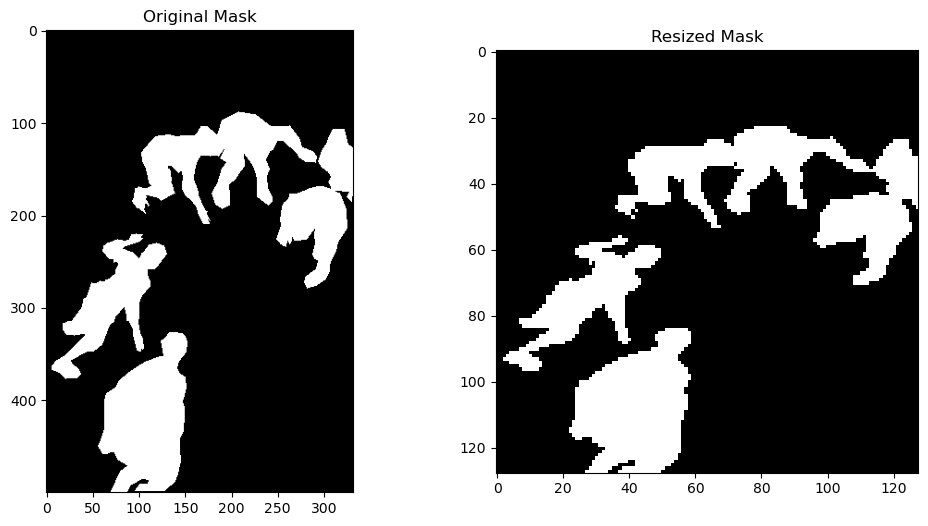

In [56]:
def visual_resized_mask(original_mask, resized_mask):
    # 원본 마스크와 리사이징된 마스크를 나란히 시각화
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original_mask, cmap='gray')
    axs[0].set_title('Original Mask')
    axs[1].imshow(resized_mask, cmap='gray')
    axs[1].set_title('Resized Mask')
    plt.show()

idx = 4251  # 예시로 이미지 선택
img_info = sampled_train_df.iloc[idx]  # 해당 인덱스의 이미지 정보 추출
path = os.path.join(train2017, img_info['file_name'])  # 이미지 파일 경로 구성
image = Image.open(path).convert("RGB")  # 이미지를 RGB 형태로 로드
original_size = image.size  # 원본 이미지의 크기 저장

# 'person' 카테고리에 해당하는 세그멘테이션 정보만 필터링하여 추출
annotations = sampled_train_df[sampled_train_df['image_id'] == img_info['image_id']]
annotations = annotations[annotations['category_id'] == 1]

# 해당 이미지의 모든 'person' 객체에 대한 세그멘테이션 정보를 리스트로 추출
# 각 객체의 첫 번째 세그멘테이션 폴리곤만 사용
segmentation_polygons = [ann['segmentation'][0] for _, ann in annotations.iterrows() if ann['segmentation']]

# 추출된 세그멘테이션 정보를 이용하여 원본 크기의 마스크를 생성
original_mask = sample_train_dataset.create_mask_for_image_and_annotation(original_size, segmentation_polygons)

# 생성된 마스크를 목표 크기로 리사이징
resized_mask = sample_train_dataset.resize_segmentation_mask(original_mask, sample_train_dataset.target_size)

# 원본 마스크와 리사이징된 마스크를 나란히 시각화하여 비교
visual_resized_mask(original_mask, resized_mask)

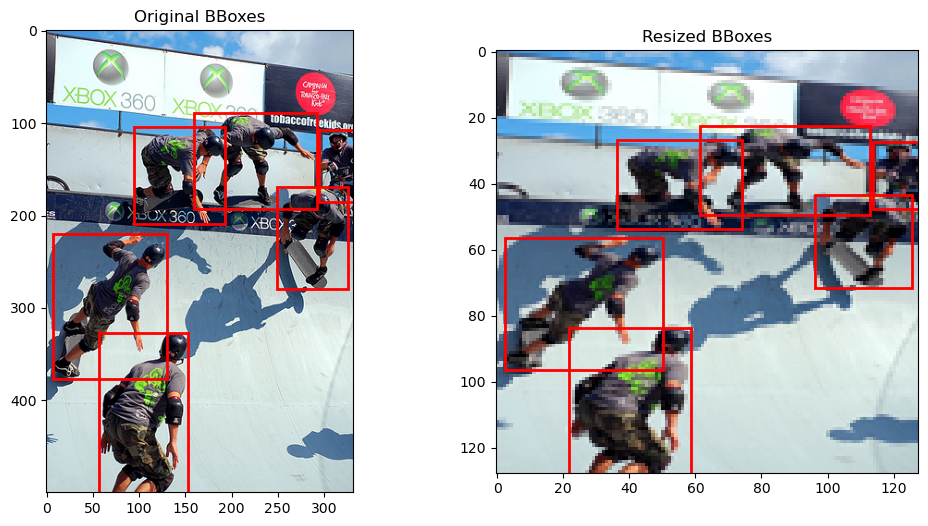

In [57]:
def visual_resized_bbox(original_image, resized_image, original_bboxes, target_size):
    # 원본 이미지와 리사이징된 이미지에 있는 모든 바운딩 박스를 시각화
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original_image)
    axs[0].set_title('Original BBoxes')
    axs[1].imshow(resized_image)
    axs[1].set_title('Resized BBoxes')

    for original_bbox in original_bboxes:
        # 원본 이미지에 바운딩 박스를 (x_min, y_min, width, height) 형식으로 그림
        rect = Rectangle((original_bbox[0], original_bbox[1]), original_bbox[2], original_bbox[3],
                         linewidth=2, edgecolor='r', facecolor='none')
        axs[0].add_patch(rect)  # 첫 번째 그래프(원본 이미지)에 바운딩 박스 추가

        # 원본 바운딩 박스를 목표 이미지 크기에 맞게 조정하여 리사이징된 이미지에 그림
        # 이는 목표 크기와 원본 이미지 크기의 비율을 사용하여 계산
        resized_bbox = [original_bbox[0] * target_size[0] / original_image.size[0],
                        original_bbox[1] * target_size[1] / original_image.size[1],
                        original_bbox[2] * target_size[0] / original_image.size[0],
                        original_bbox[3] * target_size[1] / original_image.size[1]]
        # 리사이징된 이미지에 조정된 바운딩 박스를 그림
        rect = Rectangle((resized_bbox[0], resized_bbox[1]), resized_bbox[2], resized_bbox[3],
                         linewidth=2, edgecolor='r', facecolor='none')
        axs[1].add_patch(rect)  # 두 번째 그래프(리사이징된 이미지)에 바운딩 박스 추가

    plt.show()

# 데이터셋에서 추출한 바운딩 박스 정보를 기반으로 이미지에 바운딩 박스를 그리고 리사이징된 이미지 비교
# 'annotations' 데이터프레임에서 'bbox' 컬럼의 모든 값을 리스트로 변환하여 가져옴
original_bboxes = annotations['bbox'].tolist()

# PIL 라이브러리의 resize 메소드를 사용하여 이미지를 데이터셋의 목표 크기로 리사이징
resized_image = image.resize(sample_train_dataset.target_size)

# 원본 이미지와 리사이징된 이미지에 바운딩 박스를 그리고 비교
visual_resized_bbox(image, resized_image, original_bboxes, sample_train_dataset.target_size)

In [47]:
print(annotations[['image_id', 'bbox']])
print(original_bboxes)

      image_id                              bbox
4251    414698  [218.78, 107.47, 403.97, 313.77]
4252    414698   [379.98, 92.12, 151.61, 102.67]
4253    414698    [140.06, 97.63, 88.82, 117.94]
4254    414698   [525.87, 71.67, 102.41, 115.86]
4255    414698   [259.08, 101.71, 58.53, 110.35]
4256    414698       [0.0, 96.17, 63.01, 169.72]
4257    414698    [587.84, 149.99, 52.16, 103.4]
4258    414698   [191.11, 118.76, 81.94, 142.85]
[[218.78, 107.47, 403.97, 313.77], [379.98, 92.12, 151.61, 102.67], [140.06, 97.63, 88.82, 117.94], [525.87, 71.67, 102.41, 115.86], [259.08, 101.71, 58.53, 110.35], [0.0, 96.17, 63.01, 169.72], [587.84, 149.99, 52.16, 103.4], [191.11, 118.76, 81.94, 142.85]]


In [36]:
# DataLoader에서 첫 번째 배치 데이터
first_batch_images, first_batch_targets = next(iter(sample_train_loader))

# 인덱스 1번째 이미지의 타겟 데이터에 접근
first_image_targets = first_batch_targets[1]

# 인덱스 1번째 이미지의 'masks' 데이터에 접근
first_image_masks = first_image_targets['masks']

# 'masks' 텐서의 차원을 출력
print("이미지 Masks 텐서의 차원:", first_image_masks.shape)
print(first_image_targets)

이미지 Masks 텐서의 차원: torch.Size([12, 128, 128])
{'boxes': tensor([[ 50.9860, 124.0213,  53.0960, 127.7413],
        [ 54.3600, 122.3067,  56.3240, 128.0000],
        [ 58.1540, 123.5493,  58.6260, 124.9547],
        [ 59.6940, 121.8480,  61.4560, 127.9227],
        [ 61.5500, 122.6480,  63.2320, 128.0000],
        [ 39.4480, 120.7360,  41.7320, 128.0000],
        [  0.0000, 115.5013,   4.6040, 128.0000],
        [ 64.6000, 107.5547,  87.2360, 128.0000],
        [ 36.6320, 119.6987,  39.4620, 128.0000],
        [ 41.1340, 124.0400,  43.9880, 128.0000],
        [ 45.3280, 119.7813,  48.1380, 128.0000],
        [ 49.6840, 124.4533,  50.8220, 128.0000]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
   

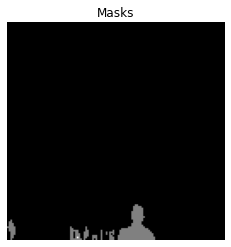

In [37]:
# 모든 마스크 시각화
plt.imshow(first_image_masks.sum(dim=0), cmap='gray')
plt.title('Masks')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


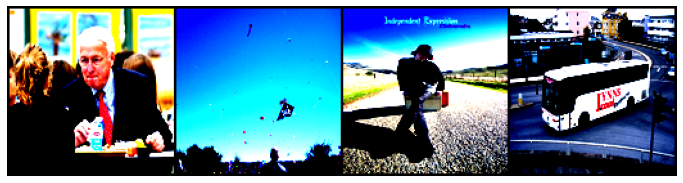

In [38]:
from torchvision.utils import make_grid

# make_grid를 이용하여 이미지 그리드 만들기
image_grid = make_grid(first_batch_images[:4])

# 이미지 그리드를 시각화
plt.figure(figsize=(12, 12))
plt.imshow(image_grid.permute(1, 2, 0))  # permute를 이용하여 채널 위치 변경
plt.axis('off')
plt.show()

In [39]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import time

def get_model_instance_segmentation(num_classes):
    
    # 사전 훈련된 Mask R-CNN 모델 불러오기
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # 분류기를 새로운 것으로 교체 (num_classes는 사용자 클래스 수 + 배경)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 새로운 것으로 교체
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 64  # 중간 레이어의 차원 수
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [40]:
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }
    torch.save(checkpoint, filename)

In [41]:
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch'] + 1  # 다음 에포크부터 시작
        loss = checkpoint['loss']
        print(f"체크포인트 로드됨. 에포크 {epoch}, 손실 {loss}")
        return epoch
    else:
        print("체크포인트 파일이 없음.")
        return 0  # 체크포인트가 없으면 0부터 시작

In [42]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()  # 모델을 학습 모드로 설정
    print_freq = 500  # 손실을 출력할 빈도 설정

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # 옵티마이저의 그라디언트를 초기화
        losses.backward()  # 손실에 대한 모델의 파라미터 기울기를 계산
        optimizer.step()  # 옵티마이저 업데이트

        if (i + 1) % print_freq == 0:
            print(f"Epoch: {epoch}, Iter: {i + 1}, Loss: {losses.item():.4f}")

    # 매 에포크마다 체크포인트 저장
    save_checkpoint(epoch, model, optimizer, losses)

# 모델, 데이터 로더, 옵티마이저 등의 설정은 이전과 동일하게 유지
# 모델 생성, 클래스는 배경을 포함해 2개 (예: 배경=0, 사람=1)
model = get_model_instance_segmentation(2)

In [43]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [44]:
# 에포크 수와 옵티마이저 설정
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
start_epoch = load_checkpoint(model, optimizer, 'checkpoint.pth')

# 이어서 학습
for epoch in range(start_epoch, num_epochs):
    train_one_epoch(model, optimizer, sample_train_loader, device, epoch)
    save_checkpoint(epoch, model, optimizer, torch.tensor(0), 'checkpoint.pth')

print("훈련 완료!")

체크포인트 로드됨. 에포크 5, 손실 0


/home/ysw4926856747/.local/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: 5, Iter: 500, Loss: 1.0349
Epoch: 5, Iter: 1000, Loss: 1.3049
Epoch: 5, Iter: 1500, Loss: 0.8030
Epoch: 5, Iter: 2000, Loss: 0.6845
Epoch: 5, Iter: 2500, Loss: 0.7136
Epoch: 5, Iter: 3000, Loss: 0.5863
Epoch: 5, Iter: 3500, Loss: 0.6132
Epoch: 5, Iter: 4000, Loss: 0.6378
Epoch: 5, Iter: 4500, Loss: 0.6905
Epoch: 5, Iter: 5000, Loss: 0.5061
Epoch: 5, Iter: 5500, Loss: 0.3941
Epoch: 6, Iter: 500, Loss: 0.4771
Epoch: 6, Iter: 1000, Loss: 0.4540
Epoch: 6, Iter: 1500, Loss: 0.4225
Epoch: 6, Iter: 2000, Loss: 0.4548
Epoch: 6, Iter: 2500, Loss: 0.3666
Epoch: 6, Iter: 3000, Loss: 0.3018
Epoch: 6, Iter: 3500, Loss: 0.3798
Epoch: 6, Iter: 4000, Loss: 0.2919
Epoch: 6, Iter: 4500, Loss: 0.3502
Epoch: 6, Iter: 5000, Loss: 0.3523
Epoch: 6, Iter: 5500, Loss: 0.3355
Epoch: 7, Iter: 500, Loss: 0.3068
Epoch: 7, Iter: 1000, Loss: 0.2773
Epoch: 7, Iter: 1500, Loss: 0.4104
Epoch: 7, Iter: 2000, Loss: 0.2657
Epoch: 7, Iter: 2500, Loss: 0.3407
Epoch: 7, Iter: 3000, Loss: 0.3136
Epoch: 7, Iter: 3500, L

In [52]:
# 모델의 상태를 파일로 저장
torch.save(model.state_dict(), 'model.pth')
print("모델 저장 완료!")

모델 저장 완료!
